In [1]:
from transformers import BertForMaskedLM, BertTokenizerFast, AutoTokenizer
import torch
from transformers import AdamW, get_scheduler
from torch.utils.data import DataLoader, random_split
from src.dataset import TurtleSoupDataset
from src.utils import plot_training_validation_loss, plot_training_validation_acc
from src.model import PET, DiffPET
from run import train_pet_model

c:\Users\wei\Desktop\programs\deep learning\turtle-soup-lateral-thinking-game\model\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [11]:
# data_path = "./data/turtle_bench1.5k_zh_tw.json"
data_path = "./data/train_data10k_zh.json"
prompt_path = "./prompts/prompt_zh.json"

In [4]:
model = BertForMaskedLM.from_pretrained("bert-base-chinese").to(device)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese")

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

In [5]:
batch_size = 16
epochs = 10
learning_rate = 1e-5

template = "根據判定規則，此玩家的猜測為[MASK]"
label_map = {
    "T": "是",
    "F": "否",
    "N": "不"
}

In [12]:
dataset = TurtleSoupDataset(data_path, prompt_path, tokenizer, max_length=512, template=template, label_map=label_map)
train_ratio = 0.85
train_size = int(len(dataset) * train_ratio)
val_size = len(dataset) - train_size

# 隨機拆分數據集
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 創建 DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## PET

In [13]:
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
num_training_steps = len(train_dataloader) * epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

c:\Users\wei\Desktop\programs\deep learning\turtle-soup-lateral-thinking-game\model\venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
pet_model = PET(model, tokenizer, device)

train_losses, train_accuracies, val_losses, val_accuracies = train_pet_model(pet_model, train_dataloader, val_dataloader, optimizer, lr_scheduler, epochs=epochs)

Epoch 1/20: 100%|██████████| 574/574 [03:48<00:00,  2.52it/s]


train_loss: 0.698, val_loss: 0.456, train_acc: 0.674, val_acc: 0.811


Epoch 2/20: 100%|██████████| 574/574 [03:45<00:00,  2.54it/s]


train_loss: 0.341, val_loss: 0.207, train_acc: 0.860, val_acc: 0.925


Epoch 3/20: 100%|██████████| 574/574 [03:48<00:00,  2.52it/s]


train_loss: 0.147, val_loss: 0.140, train_acc: 0.945, val_acc: 0.957


Epoch 4/20: 100%|██████████| 574/574 [03:45<00:00,  2.54it/s]


train_loss: 0.075, val_loss: 0.077, train_acc: 0.975, val_acc: 0.977


Epoch 5/20: 100%|██████████| 574/574 [03:49<00:00,  2.51it/s]


train_loss: 0.042, val_loss: 0.095, train_acc: 0.984, val_acc: 0.982


Epoch 6/20:  24%|██▍       | 139/574 [00:56<02:56,  2.47it/s]


KeyboardInterrupt: 

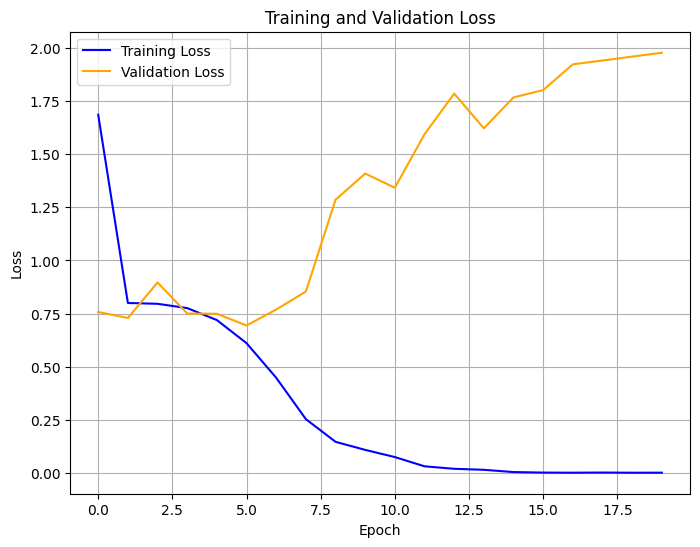

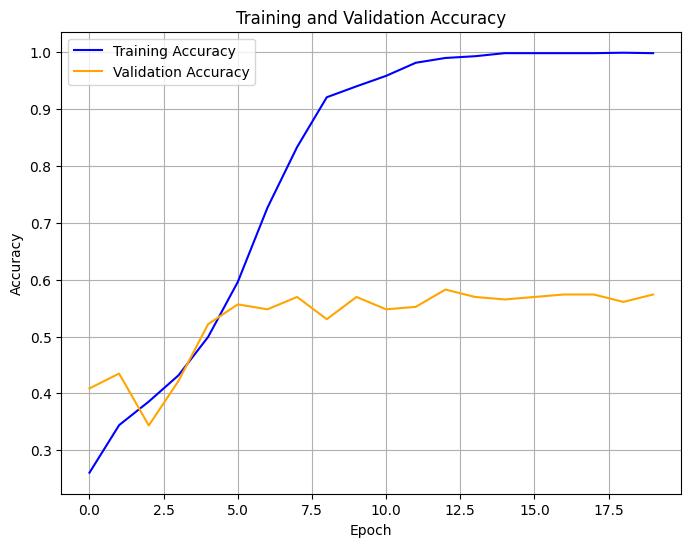

In [9]:
plot_training_validation_loss(train_losses, val_losses)
plot_training_validation_acc(train_accuracies, val_accuracies)

In [ ]:
# pet_model.save_pretrained("./params/pet_model")

## DiffPET

In [12]:
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
num_training_steps = len(train_dataloader) * epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

c:\Users\wei\Desktop\programs\deep learning\turtle-soup-lateral-thinking-game\model\venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
torch.cuda.empty_cache()

In [14]:
labels = ['是', '否', '不']

In [15]:
diff_pet_model = DiffPET(model, tokenizer, template, labels, device)

train_losses, train_accuracies, val_losses, val_accuracies = train_pet_model(diff_pet_model, train_dataloader, val_dataloader, optimizer, lr_scheduler, epochs=epochs)

Epoch 1/20: 100%|██████████| 82/82 [00:33<00:00,  2.45it/s]


train_loss: 2.116, val_loss: 1.486, train_acc: 0.238, val_acc: 0.470


Epoch 2/20: 100%|██████████| 82/82 [00:32<00:00,  2.52it/s]


train_loss: 1.317, val_loss: 1.052, train_acc: 0.474, val_acc: 0.526


Epoch 3/20: 100%|██████████| 82/82 [00:32<00:00,  2.55it/s]


train_loss: 1.155, val_loss: 0.988, train_acc: 0.515, val_acc: 0.557


Epoch 4/20: 100%|██████████| 82/82 [00:32<00:00,  2.52it/s]


train_loss: 0.995, val_loss: 0.915, train_acc: 0.558, val_acc: 0.570


Epoch 5/20: 100%|██████████| 82/82 [00:32<00:00,  2.56it/s]


train_loss: 0.859, val_loss: 1.000, train_acc: 0.619, val_acc: 0.561


Epoch 6/20: 100%|██████████| 82/82 [00:32<00:00,  2.54it/s]


train_loss: 0.744, val_loss: 0.960, train_acc: 0.676, val_acc: 0.574


Epoch 7/20: 100%|██████████| 82/82 [00:32<00:00,  2.54it/s]


train_loss: 0.657, val_loss: 0.943, train_acc: 0.724, val_acc: 0.604


Epoch 8/20: 100%|██████████| 82/82 [00:32<00:00,  2.52it/s]


train_loss: 0.496, val_loss: 1.038, train_acc: 0.795, val_acc: 0.578


Epoch 9/20: 100%|██████████| 82/82 [00:31<00:00,  2.57it/s]


train_loss: 0.419, val_loss: 1.148, train_acc: 0.829, val_acc: 0.548


Epoch 10/20: 100%|██████████| 82/82 [00:32<00:00,  2.55it/s]


train_loss: 0.348, val_loss: 1.258, train_acc: 0.862, val_acc: 0.591


Epoch 11/20: 100%|██████████| 82/82 [00:32<00:00,  2.55it/s]


train_loss: 0.217, val_loss: 1.333, train_acc: 0.923, val_acc: 0.604


Epoch 12/20: 100%|██████████| 82/82 [00:32<00:00,  2.55it/s]


train_loss: 0.172, val_loss: 1.372, train_acc: 0.947, val_acc: 0.604


Epoch 13/20: 100%|██████████| 82/82 [00:32<00:00,  2.51it/s]


train_loss: 0.144, val_loss: 1.382, train_acc: 0.951, val_acc: 0.609


Epoch 14/20: 100%|██████████| 82/82 [00:32<00:00,  2.52it/s]


train_loss: 0.111, val_loss: 1.416, train_acc: 0.962, val_acc: 0.617


Epoch 15/20: 100%|██████████| 82/82 [00:32<00:00,  2.52it/s]


train_loss: 0.087, val_loss: 1.557, train_acc: 0.973, val_acc: 0.604


Epoch 16/20: 100%|██████████| 82/82 [00:32<00:00,  2.54it/s]


train_loss: 0.063, val_loss: 1.574, train_acc: 0.984, val_acc: 0.604


Epoch 17/20: 100%|██████████| 82/82 [00:32<00:00,  2.50it/s]


train_loss: 0.075, val_loss: 1.585, train_acc: 0.976, val_acc: 0.604


Epoch 18/20: 100%|██████████| 82/82 [00:32<00:00,  2.52it/s]


train_loss: 0.061, val_loss: 1.626, train_acc: 0.985, val_acc: 0.587


Epoch 19/20: 100%|██████████| 82/82 [00:32<00:00,  2.55it/s]


train_loss: 0.054, val_loss: 1.634, train_acc: 0.985, val_acc: 0.600


Epoch 20/20: 100%|██████████| 82/82 [00:32<00:00,  2.53it/s]


train_loss: 0.045, val_loss: 1.636, train_acc: 0.990, val_acc: 0.596


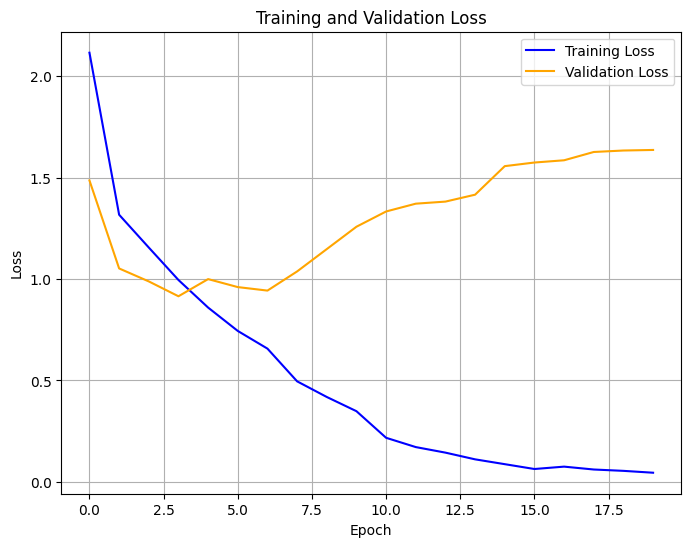

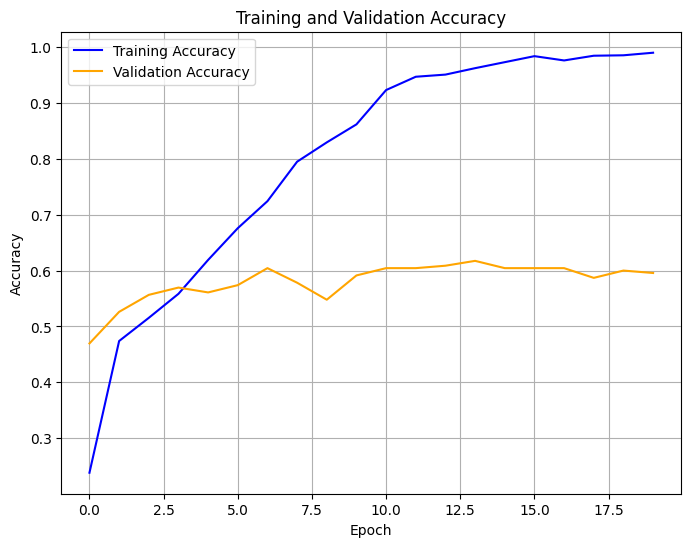

In [16]:
plot_training_validation_loss(train_losses, val_losses)
plot_training_validation_acc(train_accuracies, val_accuracies)

In [17]:
# diff_pet_model.save_model("./params/diff_pet_model")

## TEST

In [18]:
torch.cuda.empty_cache()

In [19]:
model = BertForMaskedLM.from_pretrained("./params/diff_pet_model").to(device)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-chinese")

labels = ['是', '否', '不']
template = "根據判定規則，此玩家的猜測為[MASK]"

pet = DiffPET(model, tokenizer, template, labels, device)

In [20]:
import json
import random

with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 載入 Prompt 檔案，包含 short, medium, long Prompt 的結構
with open(prompt_path, "r", encoding="utf-8") as f:
    prompts = json.load(f)

short_prompt = prompts["short"]
medium_prompt = prompts["medium"]
long_prompt = prompts["long"]

random_item = random.choice(data)

print('stroy: ', random_item['surface'])
print('answer: ', random_item['bottom'])
while True:
    user_guess = input("請輸入內容（輸入 'exit' 結束）：")
    if user_guess.lower() == 'exit':
        print("程式結束")
        break

    surface = random_item["surface"]  # 湯面部分
    bottom = random_item["bottom"]    # 湯底部分
    user_guess = user_guess  # 玩家猜測

    prompt_filled = medium_prompt["prompt"].format(surface=surface, bottom=bottom) + user_guess + ' 根據判定規則，此玩家的猜測為[MASK]'

    inputs = tokenizer(
        prompt_filled,
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    
    model.eval()
    with torch.no_grad():
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # 前向傳播
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        mask_token_index = (inputs['input_ids'] == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

        # print(logits[0, mask_token_index].shape)
        predicted_ids = torch.argmax(logits[0, mask_token_index], dim=-1)
        predicted_label = tokenizer.decode(predicted_ids, add_special_tokens=False)
        print(f"Predicted: {predicted_label}")

        # print(logits.shape)
        # predicted_ids = torch.argmax(logits, dim=-1)
        # print(predicted_ids[0])
        # predicted = tokenizer.decode(predicted_ids[0].tolist())

        # 顯示模型輸出的預測結果
        # print(f"Predicted: {[predicted]}")

stroy:  女孩每天都站在對面陽臺和我打招呼，我卻不敢再踏進陽臺了。
answer:  我新搬進了一個公寓，每天早上去陽臺晾衣服的時候，我都能看見對面公寓的陽臺上站着一個女孩在對我打招呼，我很開心，每天都準時的到陽臺跟她打完招呼再去上班。兩三個星期過去了，一天，我突然看到一條關於我小區附近的新聞：在某間公寓陽臺上發現一具女屍，已經上吊自殺三週了。我突然覺得有什麼不太對勁，跑去陽臺一看，果然女孩已經不見了，只看見幾張封條，我頓時感到一陣噁心，不敢再踏進陽臺。原來陽臺上的女屍吊在那裏搖曳的樣子只是像在打招呼而已。
Predicted: 是
Predicted: 是
Predicted: [unused16]
Predicted: [unused16]
Predicted: 不
Predicted: 不
Predicted: 是
Predicted: [unused16]
Predicted: [unused16]
Predicted: 是
Predicted: 不
Predicted: 是
Predicted: [unused16]
程式結束
